In [1]:
# loading libraries
import pandas as pd
import networkx as nx
import os
from tqdm import tqdm
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# loading and cleaning ENSG converter
test = []
geneId_geneName = {}
with open('Homo_sapiens.GRCh37.74.gtf', 'r') as file:
    for line in file:
        line = line.strip()
        data = line.split('\t')[-1]
        test.append(data)
        if 'gene_name' in data:
            attributes = data.split(';')
            geneId = attributes[0].split(' ')[1].strip('"')
            for attr in attributes:
                if 'gene_name' in attr:
                    geneName = attr.split(' ')[2].strip('"')
                    if geneId not in geneId_geneName:
                        geneId_geneName[geneId] = geneName
geneName_geneId = {v: k for k, v in geneId_geneName.items()}

In [15]:
def createRegulatory(regulatory_filepath):
    # loading, cleaning, and permutating regulatory dataset
    print(f'Loading: {regulatory_filepath}')
    regulatory = pd.read_csv(regulatory_filepath, index_col=0)
    
    exceptions = []
    for name in regulatory.index:
        try:
            regulatory = regulatory.rename(index={name: geneName_geneId[name]})
        except:
            exceptions.append(name)
    
    print(f'Row exception count: {len(exceptions)}')
    
    for exc in exceptions:
        regulatory = regulatory.drop(exc)
    
    exceptions = []
    for ID in regulatory.columns.tolist():
        if ID not in geneId_geneName:
            exceptions.append(ID)
    
    print(f'Column exception count: {len(exceptions)}')

    for exc in exceptions:
        regulatory = regulatory.drop(exc)
    
    def inverse(x):
        return 1/x
    
    def absolute(x):
        return abs(x)
    
    regulatory = regulatory.map(inverse)
    regulatory = regulatory.map(absolute)

    return regulatory

def createEndpoints(filepath):
    # loading and cleaning dataset
    endpoints = pd.read_csv(filepath, sep='\t', index_col=0)
    
    exceptions = []
    for name in endpoints.index:
        try:
            endpoints = endpoints.rename(index={name: geneName_geneId[name.upper()]})
        except:
            exceptions.append(name)
    
    print(f'Endpoints exception count: {len(exceptions)}')
    
    for exc in exceptions:
        endpoints = endpoints.drop(exc)

    return list(endpoints.index)

def createRandomEndpoints(regulatory, num, seed):
    rand = regulatory.sample(n=num, random_state=seed)
    return list(rand.index)

def createGraph(regulatory, endpoints):
    # creating network
    regMatrix = regulatory.to_numpy().tolist()
    
    G = nx.Graph()
    nodes = list(set(list(regulatory.index) + regulatory.columns.tolist() + endpoints))
    G.add_nodes_from(nodes)
    edgeCount = 0
    for rowName, row in zip(regulatory.index, regMatrix):
        for columnName, cell in zip(regulatory.columns.tolist(), row):
            # if cell < 10:
            G.add_edge(rowName, columnName, weight=cell)
            edgeCount += 1
    
    print(f'EdgeCount: {edgeCount}')

    return G

def connectionEnrichment(origins, endpoints):
    datasets = os.listdir('data')
    count = {}
    for i, dataset in enumerate(datasets):
        print(i)
        regulatory = createRegulatory(f'data/{dataset}')
        G = createGraph(regulatory, endpoints)
        for origin in origins:
            for i, endpoint in enumerate(tqdm(endpoints)):
                try:
                    path = nx.shortest_path(G, origin, endpoint, weight="weight")
                    for node in path:
                        if node not in count:
                            count[node] = 1
                        else:
                            count[node] += 1
                except:
                    pass
    return count

def sortDic(dic):
    return dict(reversed(sorted(dic.items(), key=lambda item: item[1])))

def removeOrigins(dic, num):
    dic = sortDic(dic)
    values = list(dic.values())
    return { k:v for (k,v) in dic.items() if v <= values[num]}

def printResultsWithStats(dic):
    print(f'Size: {len(dic)}')
    print(f'Average: {statistics.mean(dic.values())}')
    print(f'Median: {statistics.median(dic.values())}')
    print(dic)

In [4]:
# defining origins
OCT4 = 'ENSG00000229094'
SOX2 = 'ENSG00000181449'
KLF4 = 'ENSG00000136826'
OSKgenes = [OCT4, SOX2, KLF4]

In [5]:
# multi-dataset aging gene enrichment
globalAgingGenes = createEndpoints('global_aging_genes.tsv')
agingCount = connectionEnrichment(OSKgenes, globalAgingGenes)

Endpoints exception count: 15
0
Loading: data/Testis.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:43<00:00,  1.90it/s]


1
Loading: data/Brain_Cerebellum.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:39<00:00,  1.94it/s]


2
Loading: data/Vagina.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:39<00:00,  1.95it/s]


3
Loading: data/Esophagus_Muscularis.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:38<00:00,  1.96it/s]


4
Loading: data/Adipose_Subcutaneous.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:41<00:00,  1.91it/s]


5
Loading: data/Brain_Basal_Ganglia.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:46<00:00,  1.87it/s]


6
Loading: data/Brain_Other.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:45<00:00,  1.88it/s]


7
Loading: data/Minor_Salivary_Gland.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:43<00:00,  1.89it/s]


8
Loading: data/Esophagus_Mucosa.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:45<00:00,  1.87it/s]


9
Loading: data/Colon_Transverse.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:46<00:00,  1.86it/s]


10
Loading: data/Tibial_Nerve.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:44<00:00,  1.89it/s]


11
Loading: data/fibroblastCellLine.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:40<00:00,  1.94it/s]


12
Loading: data/Skeletal_Muscle.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:42<00:00,  1.91it/s]


13
Loading: data/Pancreas.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:44<00:00,  1.89it/s]


14
Loading: data/Gastroesophageal_Junction.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:43<00:00,  1.90it/s]


15
Loading: data/Skin.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:46<00:00,  1.87it/s]


16
Loading: data/Artery_Aorta.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:43<00:00,  1.90it/s]


17
Loading: data/Uterus.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:45<00:00,  1.88it/s]


18
Loading: data/Lung.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:47<00:00,  1.85it/s]


19
Loading: data/Adipose_Visceral.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:46<00:00,  1.86it/s]


20
Loading: data/Adrenal_Gland.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:44<00:00,  1.88it/s]


21
Loading: data/Artery_Tibial.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:51<00:00,  1.81it/s]


22
Loading: data/Heart_Atrial_Appendage.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:53<00:00,  1.79it/s]


23
Loading: data/Liver.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:49<00:00,  1.83it/s]


24
Loading: data/Kidney_Cortex.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:52<00:00,  1.80it/s]


25
Loading: data/Spleen.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:49<00:00,  1.83it/s]


26
Loading: data/Heart_Left_Ventricle.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:48<00:00,  1.84it/s]


27
Loading: data/Artery_Coronary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:48<00:00,  1.84it/s]


28
Loading: data/Whole_Blood.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:50<00:00,  1.82it/s]


29
Loading: data/Stomach.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:51<00:00,  1.81it/s]


30
Loading: data/Pituitary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:51<00:00,  1.81it/s]


31
Loading: data/Colon_Sigmoid.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:48<00:00,  1.84it/s]


32
Loading: data/Breast.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:52<00:00,  1.80it/s]


33
Loading: data/Prostate.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:51<00:00,  1.81it/s]


34
Loading: data/Thyroid.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:51<00:00,  1.81it/s]


35
Loading: data/Ovary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:49<00:00,  1.83it/s]


36
Loading: data/Intestine_Terminal_Ileum.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:51<00:00,  1.81it/s]


In [16]:
# removing OSKgenes from path
aging = removeOrigins(agingCount, len(OSKgenes))

# printing results
printResultsWithStats(aging)

Size: 1502
Average: 52.745672436751
Median: 21.0
{'ENSG00000120738': 606, 'ENSG00000115816': 573, 'ENSG00000085276': 563, 'ENSG00000189079': 558, 'ENSG00000150907': 530, 'ENSG00000128815': 491, 'ENSG00000139352': 467, 'ENSG00000090447': 447, 'ENSG00000152284': 437, 'ENSG00000204778': 405, 'ENSG00000205250': 400, 'ENSG00000184221': 394, 'ENSG00000069011': 371, 'ENSG00000174574': 358, 'ENSG00000257002': 357, 'ENSG00000188816': 350, 'ENSG00000080345': 325, 'ENSG00000164051': 319, 'ENSG00000237491': 310, 'ENSG00000164853': 306, 'ENSG00000164299': 304, 'ENSG00000177045': 302, 'ENSG00000165804': 295, 'ENSG00000135457': 280, 'ENSG00000137273': 278, 'ENSG00000129009': 276, 'ENSG00000184481': 275, 'ENSG00000198517': 261, 'ENSG00000111775': 260, 'ENSG00000113231': 258, 'ENSG00000169016': 257, 'ENSG00000001167': 255, 'ENSG00000132604': 248, 'ENSG00000114648': 247, 'ENSG00000009709': 239, 'ENSG00000243828': 234, 'ENSG00000143355': 222, 'ENSG00000120798': 221, 'ENSG00000138378': 220, 'ENSG000001108

In [17]:
# control experiment 1
datasets = os.listdir('data')
regulatory = createRegulatory(f'data/{datasets[0]}')
globalAgingGenes = createEndpoints('global_aging_genes.tsv')
randomGenes = createRandomEndpoints(regulatory, len(globalAgingGenes) + len(OSKgenes), 42)
origins = randomGenes[len(globalAgingGenes):]
endpoints = randomGenes[:len(globalAgingGenes)]
controlCount1 = connectionEnrichment(origins, endpoints)

Loading: data/Testis.csv
Row exception count: 0
Column exception count: 0
Endpoints exception count: 15
0
Loading: data/Testis.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:15<00:00,  2.28it/s]


1
Loading: data/Brain_Cerebellum.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:59<00:00,  2.60it/s]


2
Loading: data/Vagina.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:07<00:00,  2.44it/s]


3
Loading: data/Esophagus_Muscularis.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:02<00:00,  2.53it/s]


4
Loading: data/Adipose_Subcutaneous.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:03<00:00,  2.51it/s]


5
Loading: data/Brain_Basal_Ganglia.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:02<00:00,  2.54it/s]


6
Loading: data/Brain_Other.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:04<00:00,  2.49it/s]


7
Loading: data/Minor_Salivary_Gland.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:07<00:00,  2.43it/s]


8
Loading: data/Esophagus_Mucosa.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:06<00:00,  2.45it/s]


9
Loading: data/Colon_Transverse.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:03<00:00,  2.51it/s]


10
Loading: data/Tibial_Nerve.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:06<00:00,  2.46it/s]


11
Loading: data/fibroblastCellLine.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:04<00:00,  2.49it/s]


12
Loading: data/Skeletal_Muscle.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:02<00:00,  2.53it/s]


13
Loading: data/Pancreas.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:03<00:00,  2.50it/s]


14
Loading: data/Gastroesophageal_Junction.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:07<00:00,  2.44it/s]


15
Loading: data/Skin.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:12<00:00,  2.35it/s]


16
Loading: data/Artery_Aorta.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:05<00:00,  2.48it/s]


17
Loading: data/Uterus.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:06<00:00,  2.45it/s]


18
Loading: data/Lung.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:02<00:00,  2.52it/s]


19
Loading: data/Adipose_Visceral.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:03<00:00,  2.51it/s]


20
Loading: data/Adrenal_Gland.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:02<00:00,  2.52it/s]


21
Loading: data/Artery_Tibial.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:05<00:00,  2.47it/s]


22
Loading: data/Heart_Atrial_Appendage.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:03<00:00,  2.51it/s]


23
Loading: data/Liver.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:05<00:00,  2.46it/s]


24
Loading: data/Kidney_Cortex.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:05<00:00,  2.48it/s]


25
Loading: data/Spleen.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:06<00:00,  2.45it/s]


26
Loading: data/Heart_Left_Ventricle.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:03<00:00,  2.50it/s]


27
Loading: data/Artery_Coronary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:05<00:00,  2.47it/s]


28
Loading: data/Whole_Blood.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:02<00:00,  2.53it/s]


29
Loading: data/Stomach.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:05<00:00,  2.47it/s]


30
Loading: data/Pituitary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:02<00:00,  2.52it/s]


31
Loading: data/Colon_Sigmoid.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:05<00:00,  2.48it/s]


32
Loading: data/Breast.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:02<00:00,  2.53it/s]


33
Loading: data/Prostate.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:09<00:00,  2.39it/s]


34
Loading: data/Thyroid.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:07<00:00,  2.44it/s]


35
Loading: data/Ovary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:07<00:00,  2.43it/s]


36
Loading: data/Intestine_Terminal_Ileum.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:06<00:00,  2.45it/s]


In [18]:
# removing random 'OSKgenes' from path
control1 = removeOrigins(controlCount1, len(origins))

# printing results
printResultsWithStats(control1)

Size: 1666
Average: 39.90876350540216
Median: 16.0
{'ENSG00000068305': 340, 'ENSG00000185775': 316, 'ENSG00000205414': 309, 'ENSG00000234902': 273, 'ENSG00000245975': 272, 'ENSG00000269571': 247, 'ENSG00000113583': 245, 'ENSG00000149295': 235, 'ENSG00000100811': 227, 'ENSG00000261713': 224, 'ENSG00000232046': 219, 'ENSG00000111605': 208, 'ENSG00000214890': 204, 'ENSG00000231969': 202, 'ENSG00000113578': 193, 'ENSG00000125872': 186, 'ENSG00000160961': 181, 'ENSG00000170558': 178, 'ENSG00000175646': 172, 'ENSG00000167862': 168, 'ENSG00000120149': 168, 'ENSG00000270010': 164, 'ENSG00000136574': 164, 'ENSG00000170606': 162, 'ENSG00000248482': 161, 'ENSG00000236200': 154, 'ENSG00000101361': 154, 'ENSG00000227036': 152, 'ENSG00000119866': 150, 'ENSG00000261553': 148, 'ENSG00000123685': 145, 'ENSG00000197587': 144, 'ENSG00000237039': 144, 'ENSG00000236554': 138, 'ENSG00000164175': 136, 'ENSG00000178921': 132, 'ENSG00000134508': 132, 'ENSG00000175329': 129, 'ENSG00000117859': 129, 'ENSG0000025

In [19]:
# control experiment 2
datasets = os.listdir('data')
regulatory = createRegulatory(f'data/{datasets[0]}')
globalAgingGenes = createEndpoints('global_aging_genes.tsv')
randomGenes = createRandomEndpoints(regulatory, len(globalAgingGenes) + len(OSKgenes), 43)
origins = randomGenes[len(globalAgingGenes):]
endpoints = randomGenes[:len(globalAgingGenes)]
controlCount2 = connectionEnrichment(origins, endpoints)

Loading: data/Testis.csv
Row exception count: 0
Column exception count: 0
Endpoints exception count: 15
0
Loading: data/Testis.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:33<00:00,  3.31it/s]


1
Loading: data/Brain_Cerebellum.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:30<00:00,  3.41it/s]


2
Loading: data/Vagina.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:40<00:00,  3.09it/s]


3
Loading: data/Esophagus_Muscularis.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:34<00:00,  3.27it/s]


4
Loading: data/Adipose_Subcutaneous.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:35<00:00,  3.24it/s]


5
Loading: data/Brain_Basal_Ganglia.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:36<00:00,  3.21it/s]


6
Loading: data/Brain_Other.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:37<00:00,  3.17it/s]


7
Loading: data/Minor_Salivary_Gland.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:36<00:00,  3.20it/s]


8
Loading: data/Esophagus_Mucosa.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:37<00:00,  3.18it/s]


9
Loading: data/Colon_Transverse.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:40<00:00,  3.09it/s]


10
Loading: data/Tibial_Nerve.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:34<00:00,  3.28it/s]


11
Loading: data/fibroblastCellLine.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:40<00:00,  3.08it/s]


12
Loading: data/Skeletal_Muscle.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:36<00:00,  3.21it/s]


13
Loading: data/Pancreas.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:35<00:00,  3.25it/s]


14
Loading: data/Gastroesophageal_Junction.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:35<00:00,  3.24it/s]


15
Loading: data/Skin.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:37<00:00,  3.19it/s]


16
Loading: data/Artery_Aorta.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:37<00:00,  3.19it/s]


17
Loading: data/Uterus.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.10it/s]


18
Loading: data/Lung.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:36<00:00,  3.20it/s]


19
Loading: data/Adipose_Visceral.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.11it/s]


20
Loading: data/Adrenal_Gland.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:40<00:00,  3.10it/s]


21
Loading: data/Artery_Tibial.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:35<00:00,  3.25it/s]


22
Loading: data/Heart_Atrial_Appendage.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:36<00:00,  3.20it/s]


23
Loading: data/Liver.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.11it/s]


24
Loading: data/Kidney_Cortex.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.12it/s]


25
Loading: data/Spleen.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:35<00:00,  3.23it/s]


26
Loading: data/Heart_Left_Ventricle.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.13it/s]


27
Loading: data/Artery_Coronary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:36<00:00,  3.20it/s]


28
Loading: data/Whole_Blood.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:35<00:00,  3.24it/s]


29
Loading: data/Stomach.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:36<00:00,  3.21it/s]


30
Loading: data/Pituitary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:37<00:00,  3.17it/s]


31
Loading: data/Colon_Sigmoid.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:41<00:00,  3.07it/s]


32
Loading: data/Breast.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.11it/s]


33
Loading: data/Prostate.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.10it/s]


34
Loading: data/Thyroid.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:34<00:00,  3.29it/s]


35
Loading: data/Ovary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:40<00:00,  3.10it/s]


36
Loading: data/Intestine_Terminal_Ileum.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:41<00:00,  3.05it/s]


In [20]:
# removing random 'OSKgenes' from path
control2 = removeOrigins(controlCount2, len(origins))

# printing results
printResultsWithStats(control2)

Size: 1738
Average: 38.77790563866513
Median: 13.5
{'ENSG00000168528': 466, 'ENSG00000259612': 335, 'ENSG00000171488': 310, 'ENSG00000212961': 300, 'ENSG00000266903': 294, 'ENSG00000231027': 283, 'ENSG00000175267': 280, 'ENSG00000231031': 277, 'ENSG00000233073': 255, 'ENSG00000182636': 250, 'ENSG00000188716': 228, 'ENSG00000233074': 222, 'ENSG00000117036': 210, 'ENSG00000236417': 203, 'ENSG00000169564': 198, 'ENSG00000033627': 192, 'ENSG00000267970': 190, 'ENSG00000237638': 188, 'ENSG00000165996': 181, 'ENSG00000247809': 176, 'ENSG00000231028': 170, 'ENSG00000196776': 170, 'ENSG00000249917': 165, 'ENSG00000181885': 163, 'ENSG00000177993': 163, 'ENSG00000236213': 161, 'ENSG00000179914': 159, 'ENSG00000129518': 155, 'ENSG00000103355': 154, 'ENSG00000116147': 153, 'ENSG00000153292': 150, 'ENSG00000135638': 146, 'ENSG00000237637': 142, 'ENSG00000239402': 140, 'ENSG00000237529': 137, 'ENSG00000198131': 136, 'ENSG00000081059': 136, 'ENSG00000174898': 134, 'ENSG00000204172': 133, 'ENSG0000018

In [21]:
# control experiment 3
datasets = os.listdir('data')
regulatory = createRegulatory(f'data/{datasets[0]}')
globalAgingGenes = createEndpoints('global_aging_genes.tsv')
randomGenes = createRandomEndpoints(regulatory, len(globalAgingGenes) + len(OSKgenes), 44)
origins = randomGenes[len(globalAgingGenes):]
endpoints = randomGenes[:len(globalAgingGenes)]
controlCount3 = connectionEnrichment(origins, endpoints)

Loading: data/Testis.csv
Row exception count: 0
Column exception count: 0
Endpoints exception count: 15
0
Loading: data/Testis.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:42<00:00,  3.02it/s]


1
Loading: data/Brain_Cerebellum.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:37<00:00,  3.17it/s]


2
Loading: data/Vagina.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.12it/s]


3
Loading: data/Esophagus_Muscularis.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:37<00:00,  3.17it/s]


4
Loading: data/Adipose_Subcutaneous.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.10it/s]


5
Loading: data/Brain_Basal_Ganglia.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:38<00:00,  3.14it/s]


6
Loading: data/Brain_Other.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:36<00:00,  3.22it/s]


7
Loading: data/Minor_Salivary_Gland.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:38<00:00,  3.14it/s]


8
Loading: data/Esophagus_Mucosa.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:36<00:00,  3.23it/s]


9
Loading: data/Colon_Transverse.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:41<00:00,  3.04it/s]


10
Loading: data/Tibial_Nerve.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.12it/s]


11
Loading: data/fibroblastCellLine.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:38<00:00,  3.14it/s]


12
Loading: data/Skeletal_Muscle.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.12it/s]


13
Loading: data/Pancreas.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.11it/s]


14
Loading: data/Gastroesophageal_Junction.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.11it/s]


15
Loading: data/Skin.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.11it/s]


16
Loading: data/Artery_Aorta.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:41<00:00,  3.06it/s]


17
Loading: data/Uterus.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:38<00:00,  3.13it/s]


18
Loading: data/Lung.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:40<00:00,  3.07it/s]


19
Loading: data/Adipose_Visceral.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:40<00:00,  3.10it/s]


20
Loading: data/Adrenal_Gland.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:41<00:00,  3.07it/s]


21
Loading: data/Artery_Tibial.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:40<00:00,  3.08it/s]


22
Loading: data/Heart_Atrial_Appendage.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:42<00:00,  3.03it/s]


23
Loading: data/Liver.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:42<00:00,  3.04it/s]


24
Loading: data/Kidney_Cortex.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:38<00:00,  3.16it/s]


25
Loading: data/Spleen.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:37<00:00,  3.18it/s]


26
Loading: data/Heart_Left_Ventricle.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:40<00:00,  3.07it/s]


27
Loading: data/Artery_Coronary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:40<00:00,  3.09it/s]


28
Loading: data/Whole_Blood.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:41<00:00,  3.06it/s]


29
Loading: data/Stomach.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:41<00:00,  3.05it/s]


30
Loading: data/Pituitary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:41<00:00,  3.04it/s]


31
Loading: data/Colon_Sigmoid.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:41<00:00,  3.06it/s]


32
Loading: data/Breast.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:39<00:00,  3.11it/s]


33
Loading: data/Prostate.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:35<00:00,  3.25it/s]


34
Loading: data/Thyroid.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:40<00:00,  3.10it/s]


35
Loading: data/Ovary.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:36<00:00,  3.20it/s]


36
Loading: data/Intestine_Terminal_Ileum.csv
Row exception count: 0
Column exception count: 0
EdgeCount: 19476492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:42<00:00,  3.02it/s]


In [22]:
# removing random 'OSKgenes' from path
control3 = removeOrigins(controlCount3, len(origins))

# printing results
printResultsWithStats(control3)

Size: 1725
Average: 38.75594202898551
Median: 14
{'ENSG00000146830': 324, 'ENSG00000270614': 323, 'ENSG00000197905': 289, 'ENSG00000251461': 248, 'ENSG00000108823': 245, 'ENSG00000233627': 233, 'ENSG00000116991': 224, 'ENSG00000197951': 222, 'ENSG00000231226': 220, 'ENSG00000184032': 217, 'ENSG00000168269': 204, 'ENSG00000074317': 201, 'ENSG00000205922': 201, 'ENSG00000127995': 196, 'ENSG00000183891': 193, 'ENSG00000260223': 184, 'ENSG00000143867': 181, 'ENSG00000173153': 175, 'ENSG00000116691': 175, 'ENSG00000128185': 174, 'ENSG00000169564': 173, 'ENSG00000263072': 173, 'ENSG00000108511': 162, 'ENSG00000266774': 159, 'ENSG00000070756': 157, 'ENSG00000084733': 157, 'ENSG00000172081': 157, 'ENSG00000272780': 151, 'ENSG00000051108': 151, 'ENSG00000236430': 149, 'ENSG00000235138': 144, 'ENSG00000198018': 144, 'ENSG00000196115': 143, 'ENSG00000183496': 143, 'ENSG00000115350': 142, 'ENSG00000163884': 142, 'ENSG00000165655': 141, 'ENSG00000255364': 140, 'ENSG00000100811': 139, 'ENSG000001627

Text(0.5, 0, 'Number of overlaps')

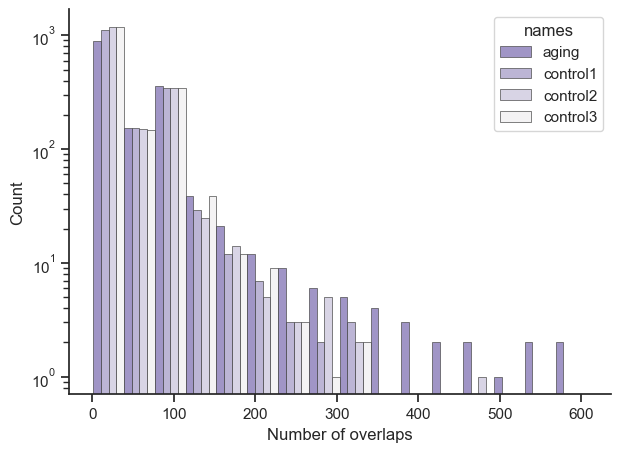

In [24]:
# creating graph
agingVal = [values for key, values in aging.items()]
controlVal1 = [values for key, values in control1.items()]
controlVal2 = [values for key, values in control2.items()]
controlVal3 = [values for key, values in control3.items()]
agingName = ['aging' for i in range(len(agingVal))]
controlName1 = ['control1' for i in range(len(controlVal1))]
controlName2 = ['control2' for i in range(len(controlVal2))]
controlName3 = ['control3' for i in range(len(controlVal3))]

counts = agingVal + controlVal1 + controlVal2 + controlVal3
names = agingName + controlName1 + controlName2 + controlName3

df = pd.DataFrame({'counts': counts, 'names': names})

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    df,
    x="counts", hue="names",
    multiple="dodge",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    bins = 16,
)

plt.yscale('log')
plt.xlabel("Number of overlaps")

In [42]:
for name1, dataset1 in zip(['aging', 'control1', 'control2', 'control3'], [aging, control1, control2, control3]):
    print(f'Origin: {name1}')
    for name2, dataset2 in zip(['aging', 'control1', 'control2', 'control3'], [aging, control1, control2, control3]):
        print(f'Endpoint: {name2}')
        intersection = set(dataset1).intersection(set(dataset2))
        sideTotal2 = sum([dataset2[i] for i in intersection])
        print(len(intersection))
        print(sideTotal2)

Origin: aging
Endpoint: aging
1502
79224
Endpoint: control1
342
30600
Endpoint: control2
314
28700
Endpoint: control3
330
29786
Origin: control1
Endpoint: aging
342
21073
Endpoint: control1
1666
66488
Endpoint: control2
245
20015
Endpoint: control3
243
19926
Origin: control2
Endpoint: aging
314
15724
Endpoint: control1
245
19647
Endpoint: control2
1738
67396
Endpoint: control3
257
20793
Origin: control3
Endpoint: aging
330
21856
Endpoint: control1
243
20080
Endpoint: control2
257
21790
Endpoint: control3
1725
66854
